In [1]:
# Load data ke dalam data frame 
import pandas as pd

# spesifikasi encoding diperlukan karena data tidak menggunakan UTF-8
df = pd.read_csv('sentimen_SK-NS.csv', encoding='latin-1') 

df.head()

,review_tokens_SR,Sentimen
0,kecewa banget pesan free pouch dikirimnya cott...,Negatif
1,kali pengemasan tidak safe sepertinya tutup bo...,Negatif
2,paket datangnya barang pecah return seller iku...,Negatif
3,enggak sabun nya enggak sesuai deskripsi,Negatif
4,enggak sesuai harapan,Negatif


In [2]:
# Cek jumlah data per kelas
print(df['Sentimen'].value_counts())
print('\n')

# Cek kelengkapan data
print(df.info())
print('\n')

# Cek statistik deskriptif
print(df.describe())

Positif    87
Netral     85
Negatif    75
Name: Sentimen, dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 247 entries, 0 to 246
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   review_tokens_SR  247 non-null    object
 1   Sentimen          247 non-null    object
dtypes: object(2)
memory usage: 4.0+ KB
None


       review_tokens_SR Sentimen
count               247      247
unique              239        3
top        terima kasih  Positif
freq                  3       87


In [3]:
# Data untuk label
new_labels = {
    'Negatif' : 0,
    'Netral' : 1,
    'Positif' : 2
}

# Encode label (mengubah label dari spam dan ham menjadi 1 dan 0)
df['Sentimen'] = df['Sentimen'].map(new_labels)

# Cek data teratas
df.head()

,review_tokens_SR,Sentimen
0,kecewa banget pesan free pouch dikirimnya cott...,0
1,kali pengemasan tidak safe sepertinya tutup bo...,0
2,paket datangnya barang pecah return seller iku...,0
3,enggak sabun nya enggak sesuai deskripsi,0
4,enggak sesuai harapan,0


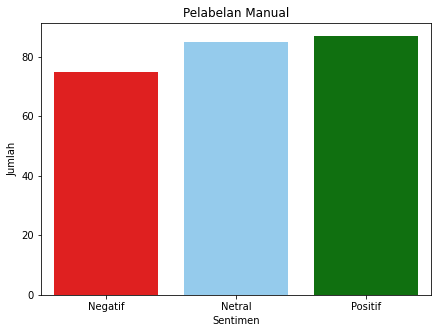

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# Warna untuk setiap kategori sentimen
palette = {0: 'red', 1: 'lightskyblue', 2: 'green'}

# visualisasi sentimen positif, netral, dan negatif
plt.figure(figsize=(7, 5))
sns.countplot(data=df, x='Sentimen', palette=palette)
plt.title('Pelabelan Manual')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah')

# Mengganti label x-axis
plt.xticks([0, 1, 2], ['Negatif', 'Netral', 'Positif'])

plt.show()

In [5]:
# Memisahkan fitur dengan label
X = df['review_tokens_SR'].values
y = df['Sentimen'].values

In [6]:
# Ekstraksi fitur
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import ComplementNB
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

# Inisialisasi model
mnb = ComplementNB(alpha=1.0 , fit_prior=True, class_prior=None)

# Membuat objek StratifiedKFold untuk 10-fold cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Inisialisasi TfidfVectorizer
bow = TfidfVectorizer(max_features=510)


# List untuk menyimpan prediksi dan label sebenarnya dari setiap lipatan
all_predictions_testing = []
all_true_labels_testing = []
all_predictions_training = []
all_true_labels_training = []

# Loop melalui setiap lipatan (fold) dalam cross-validation
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]  # Data latih dan uji
    y_train, y_test = y[train_index], y[test_index]  # Label data latih dan uji

    # Transformasi seluruh data menggunakan TfidfVectorizer
    X_train_transform = bow.fit_transform(X_train)
    X_test_transform = bow.transform(X_test)

    # Melatih model klasifikasi pada data latih
    mnb.fit(X_train_transform, y_train)

    # Membuat prediksi pada data uji
    predictions_testing = mnb.predict(X_test_transform)

    # Menambahkan prediksi dan label sebenarnya ke dalam list
    all_predictions_testing.extend(predictions_testing)
    all_true_labels_testing.extend(y_test)

    # Membuat prediksi pada data training
    predictions_training = mnb.predict(X_train_transform)

    # Menambahkan prediksi dan label sebenarnya ke dalam list
    all_predictions_training.extend(predictions_training)
    all_true_labels_training.extend(y_train)

In [7]:
# Hitung metrik evaluasi
accuracy_training = accuracy_score(all_true_labels_training, all_predictions_training)
precision_training = precision_score(all_true_labels_training, all_predictions_training, average='weighted')
recall_training = recall_score(all_true_labels_training, all_predictions_training, average='weighted')
f1_training = f1_score(all_true_labels_training, all_predictions_training, average='weighted')

# Print hasil
print("------- AKURASI TRAINING -------")
print("Overall accuracy:", accuracy_training)
print("Overall precision:", precision_training)
print("Overall recall:", recall_training)
print("Overall F1-score:", f1_training)

print(f'Confusion Matrix : \n {confusion_matrix(all_true_labels_training, all_predictions_training)}')
print('-----------------------------------------------------\n')
print(classification_report(all_true_labels_training, all_predictions_training, zero_division=0))


------- AKURASI TRAINING -------
Overall accuracy: 0.8937246963562753
Overall precision: 0.8954539651908072
Overall recall: 0.8937246963562753
Overall F1-score: 0.8941139852967087
Confusion Matrix : 
 [[276  11  13]
 [  4 293  43]
 [  8  26 314]]
-----------------------------------------------------

              precision    recall  f1-score   support

           0       0.96      0.92      0.94       300
           1       0.89      0.86      0.87       340
           2       0.85      0.90      0.87       348

    accuracy                           0.89       988
   macro avg       0.90      0.89      0.90       988
weighted avg       0.90      0.89      0.89       988



In [8]:
# Hitung metrik evaluasi
accuracy_testing = accuracy_score(all_true_labels_testing, all_predictions_testing)
precision_testing = precision_score(all_true_labels_testing, all_predictions_testing, average='weighted')
recall_testing = recall_score(all_true_labels_testing, all_predictions_testing, average='weighted')
f1_testing = f1_score(all_true_labels_testing, all_predictions_testing, average='weighted')

# Print hasil
print("------- AKURASI TESTING -------")
print("Overall accuracy:", accuracy_testing)
print("Overall precision:", precision_testing)
print("Overall recall:", recall_testing)
print("Overall F1-score:", f1_testing)

print(f'Confusion Matrix : \n {confusion_matrix(all_true_labels_testing, all_predictions_testing)}')
print('-----------------------------------------------------\n')
print(classification_report(all_true_labels_testing, all_predictions_testing, zero_division=0))

------- AKURASI TESTING -------
Overall accuracy: 0.5546558704453441
Overall precision: 0.551146255437103
Overall recall: 0.5546558704453441
Overall F1-score: 0.5521875892002871
Confusion Matrix : 
 [[52 14  9]
 [14 41 30]
 [17 26 44]]
-----------------------------------------------------

              precision    recall  f1-score   support

           0       0.63      0.69      0.66        75
           1       0.51      0.48      0.49        85
           2       0.53      0.51      0.52        87

    accuracy                           0.55       247
   macro avg       0.55      0.56      0.56       247
weighted avg       0.55      0.55      0.55       247



In [54]:
new_text = input("\nMasukkan teks baru: ")
new_text_vec = bow.transform([new_text])
predicted_sentimen = mnb.predict(new_text_vec)

if predicted_sentimen[0] == 0:
    sentiment_label = "negatif"
elif predicted_sentimen[0] == 1:
    sentiment_label = "netral"
elif predicted_sentimen[0] == 2:
    sentiment_label = "positif"

print("Hasil Analisis Sentimen untuk Teks Baru : ", sentiment_label)

Hasil Analisis Sentimen untuk Teks Baru :  negatif
